# PLAsTiCC data exploration with TAPE

Let's explore [PLAsTiCC](http://plasticc.org) data!

It is publically avilable through [this Zenodo repository](https://zenodo.org/record/2539456).

In [1]:
## Uncomment to install packages

# !pip install tape joblib requests

In [2]:
%load_ext memory_profiler

from pathlib import Path

### Download the data

Please get the data from [Zenodo](https://zenodo.org/record/2539456) and put them to the `./plasticc` folder (you may change the location bellow with `DATA_DIR`).

In [3]:
DATA_DIR = Path("./plasticc")

META_FILENAME = "plasticc_test_metadata.csv.gz"
LC_FILENAMES = [f"plasticc_test_lightcurves_{i:02d}.csv.gz" for i in range(1, 12)]
# META_FILENAME = "plasticc_train_metadata.csv.gz"
# LC_FILENAMES = ['plasticc_train_lightcurves.csv.gz']

N_PARTITIONS = len(LC_FILENAMES)

You may skip the next cell if you already have the data downloaded in the `DATA_DIR`.

# Read and analyse the data with TAPE

In [4]:
%%time

import light_curve as licu
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# In TAPE's (and LSST's) terminology, sources are individual detections,
# and objects are the underlying astrophysical objects.

# We load object table first, from the metadata file.
print("Loading object table...")
object_table = dd.read_csv(
    DATA_DIR / META_FILENAME,
)
object_table = object_table.set_index('object_id', sorted=True, sort=False, divisions=[13, 130788054])

# Then we load the sources:
print("Loading source tables...")
source_table = dd.read_csv(
    [DATA_DIR / filename for filename in LC_FILENAMES],
)
source_table = source_table.set_index('object_id', sorted=True, sort=False, divisions=[13, 1000183, 13952428, 26956806, 39933855, 52935297, 65930419, 78887012, 91875367, 104853940, 117792961, 130788054])

# Now we can make an Ensemble.
# To make parallel processing work we need to partition the data.
# After that, when we run analysis, TAPE will distribute the work:
# one partition per worker.
print("Building Ensemble...")
# ens = Ensemble(dashboard_address="127.0.0.1:8787", memory_limit='16GB')
ens = Ensemble(memory_limit='16GB', n_workers=2)
ens.from_dask_dataframe(
    source_frame=source_table,
    object_frame=object_table,
    # npartitions=N_PARTITIONS,
    npartitions=None,
    column_mapper=ColumnMapper(
        id_col='object_id',
        time_col='mjd',
        flux_col='flux',
        err_col='flux_err',
        band_col='passband',
    ),
)

assert False

# Let's run some analysis!

print("Starting analysis...")
# First, let's select only Galactic objects, by cutting on hostgal_photoz.
print("First, filter by photoz")
ens = ens.query("hostgal_photoz < 1e-3", table="object")

# Second, let's select persistent sources, by cutting on the duration of the light curve.
print("Extract durations")
duration = ens.batch(
    lambda time, detected: np.ptp(time[np.asarray(detected, dtype=bool)]),
    ens._time_col, 'detected_bool',
    meta=('duration', "float64"),
)
print("assign a column")
ens.assign(table="object", duration=duration)
print("Filter by duration")
ens = ens.query("duration > 366", table="object")

# Next, we use Otsu's method to split light curves into two groups:
# one with high flux, and one with low flux. Eclipsing binaries should have
# lower flux group smaller than the higher flux group, but having larger 
# variability. We use light-curve package to extract these features.
# (https://github.com/light-curve/light-curve-python)
# For simplicity, we only calculate these features for the r band.
otsu_features = ens.batch(licu.OtsuSplit(), band_to_calc='r')
otsu_features

Loading object table...
Loading source tables...
Building Ensemble...


/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/dask/dataframe/io/csv.py:544: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/dask/dataframe/io/csv.py:544: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(
/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/dask/dataframe/core.py:5251: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/dask/dataframe/core.py:5251: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/Users/h

KilledWorker: Attempted to run task ('lambda-34d03d66675d3ee0287e9289a654966f', 3) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:59374. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

### Do the same, but with bare Pandas + PyArrow and nested arrays

In [5]:
%%time
%%memit

import light_curve as licu
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pacsv
from joblib import Parallel, delayed

# Read the data
# -------------

# First we load object table, from the metadata file.
print("Loading object table...")
object_table = pacsv.read_csv(
    DATA_DIR / META_FILENAME,
    # We'd like to load the whole file into a single partition
    read_options=pacsv.ReadOptions(block_size=(1<<31)-1),
)
object_table = pd.DataFrame(
    {
        col: pd.Series(
            object_table[col],
            dtype=pd.ArrowDtype(object_table[col].type),
            index=object_table['object_id'],
            copy=False,
        )
        for col in object_table.column_names if col != 'object_id'
    },
)

# Then we load the sources:
print("Loading source tables...")

def read_source_table(filename):
    table = pacsv.read_csv(
        DATA_DIR / filename,
        # We'd like to have a partition per an original file
        read_options=pacsv.ReadOptions(block_size=(1<<31)-1),
    )
    return pd.DataFrame(
        {
            col: pd.Series(
                table[col],
                dtype=pd.ArrowDtype(table[col].type),
                index=table['object_id'],
                copy=False,
            )
            for col in table.column_names if col != 'object_id'
        },
    )

# source_tables = []
# for filename in LC_FILENAMES:
#     source_table = pa.csv.read_csv(
#         DATA_DIR / filename,
#         # We'd like to have a partition per an original file
#         read_options=pa.csv.ReadOptions(block_size=(1<<31)-1),
#     )
#     source_tables.append(pd.DataFrame(
#         {
#             col: pd.Series(
#                 source_table[col],
#                 dtype=pd.ArrowDtype(source_table[col].type),
#                 index=source_table['object_id'],
#                 copy=False,
#             )
#             for col in source_table.column_names if col != 'object_id'
#         },
#     ))
source_tables = Parallel(backend='threading', n_jobs=4)(
    delayed(read_source_table)(filename) for filename in LC_FILENAMES[1:2]
)
source_table = pd.concat(source_tables, ignore_index=True, sort=False)


# Add sources to the object table
# -------------------------------

# First, let's do some sanity checks
print("Sanity checks...")
np.testing.assert_array_equal(
    object_table.index.values,
    np.unique(object_table.index.values),
    err_msg="Object table has duplicate indices or is not sorted.",
)
assert np.all(np.diff(source_table.index) >= 0), "Source table index must be sorted."

# We need an offsets array to know where each source light curve starts.
source_offsets = []
for table in source_tables:
    offset = np.nonzero(np.diff(table.index, prepend=-1, append=-1))[0]
    source_offsets.append(pa.array(offset))

# Update the object table with list-arrays built from the source table

print("Updating object table with list-arrays...")
for column in source_table.columns:
    list_arrays = []
    for table, offset in zip(source_tables, source_offsets):
        list_arrays.append(pa.ListArray.from_arrays(
            offset,
            pa.array(table[column]),
        ))
    chunked_array = pa.chunked_array(list_arrays)
    object_table[column] = pd.Series(
        chunked_array,
        dtype=pd.ArrowDtype(chunked_array.type),
        index=object_table.index,
    )
    
# Do analysis
# -----------

print("Starting analysis...")
# First, let's select only Galactic objects, by cutting on hostgal_photoz.
df = object_table[object_table['hostgal_photoz'] < 1e-3]

# Second, let's select persistent sources, by cutting on the duration of the light curve.
df['duration'] = df[['mjd', 'detected_bool']].apply(
    lambda row: np.ptp(row['mjd'][np.asarray(row['detected_bool'], dtype=bool)]),
    axis=1
)
df = df[df['duration'] > 366]

# Next, we use Otsu's method to split light curves into two groups:
# one with high flux, and one with low flux. Eclipsing binaries should have
# lower flux group significantly smaller than the higher flux group,
# but having larger variability.
# We use light-curve package to extract these features.
# (https://github.com/light-curve/light-curve-python)
# For simplicity, we only calculate these features for the r band.
def extract_band(*arrays, bands, band_to_calc):
    mask = np.asarray(bands) == band_to_calc
    return [np.asarray(arr)[mask] for arr in arrays]

otsu_split = licu.OtsuSplit()
otsu_features = df[['mjd', 'flux', 'flux_err', 'passband']].apply(
    lambda row: pd.Series(
        otsu_split(
            # *extract_band(
                row['mjd'],
                row['flux'],
                row['flux_err'],
                # bands=row['passband'],
                # band_to_calc=2,  # r band
            # ),
            sorted=True,
            check=False,
        ),
        index=otsu_split.names,
    ),
    axis=1
)

df = df[otsu_features['otsu_lower_to_all_ratio'] < 0.1]
df = df[otsu_features['otsu_std_lower'] > otsu_features['otsu_std_upper']]

Loading object table...
Loading source tables...
Sanity checks...
Updating object table with list-arrays...
Starting analysis...


<timed exec>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2min 38s, sys: 50 s, total: 3min 28s
Wall time: 1min 33s


<timed exec>:155: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
df.shape[0], np.mean(df['true_target'] == 16)

(31221, 0.907177861055059)

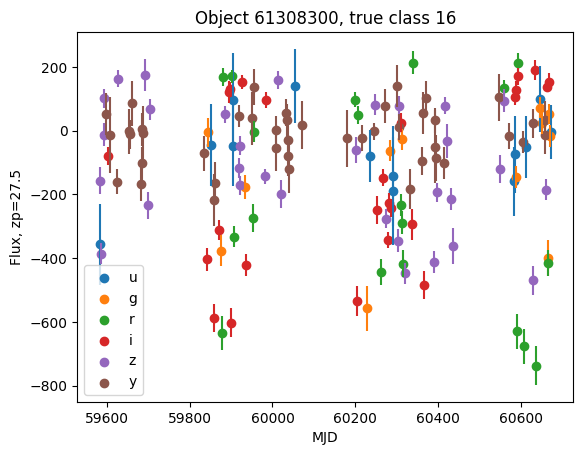

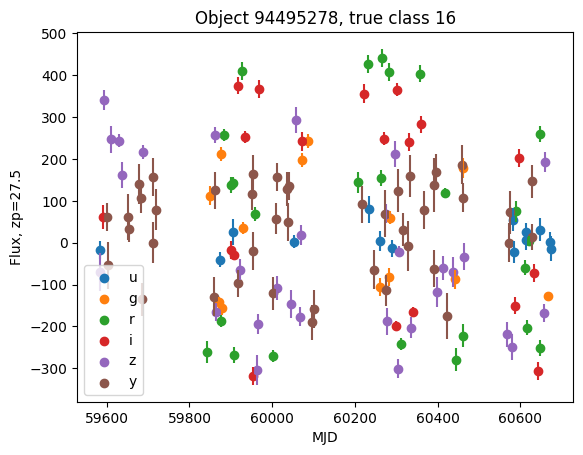

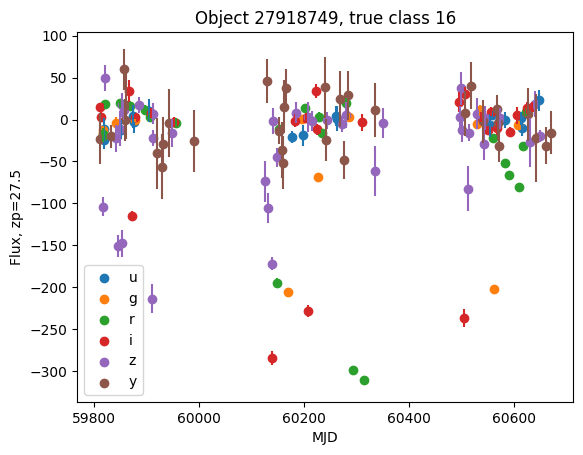

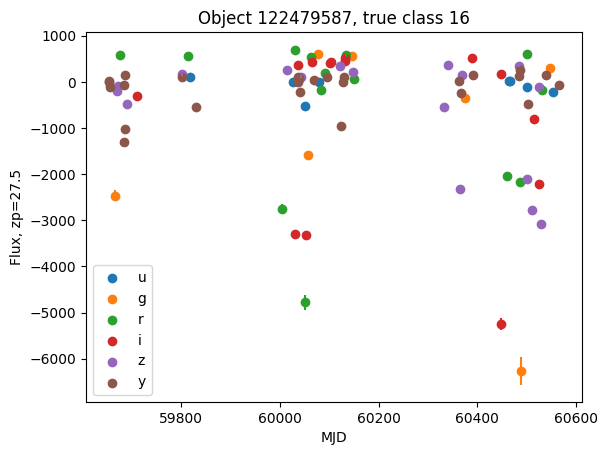

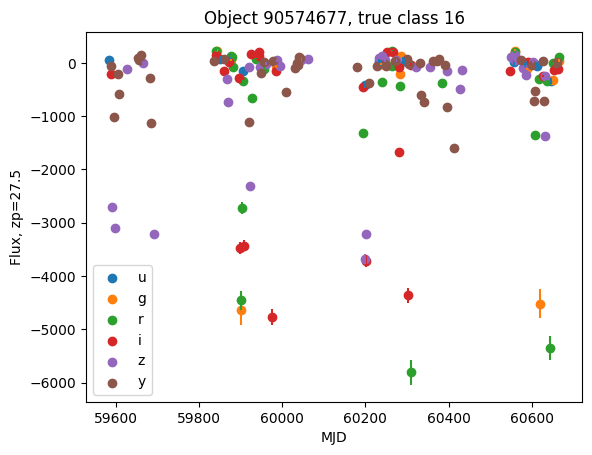

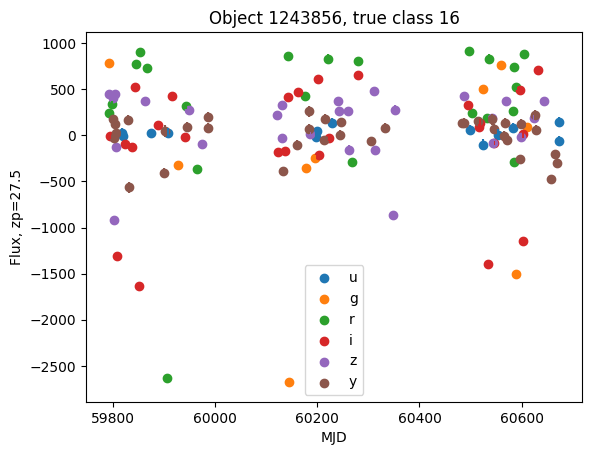

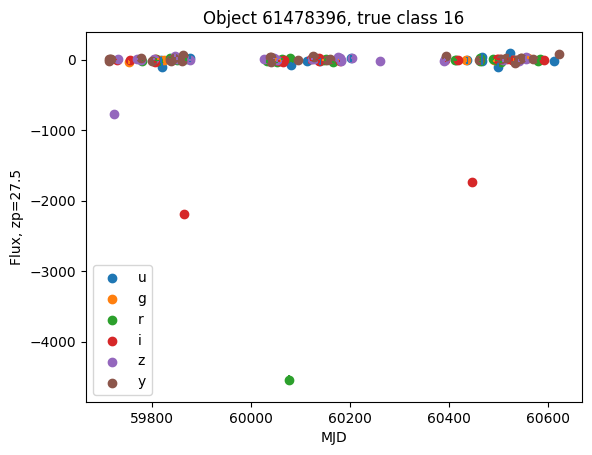

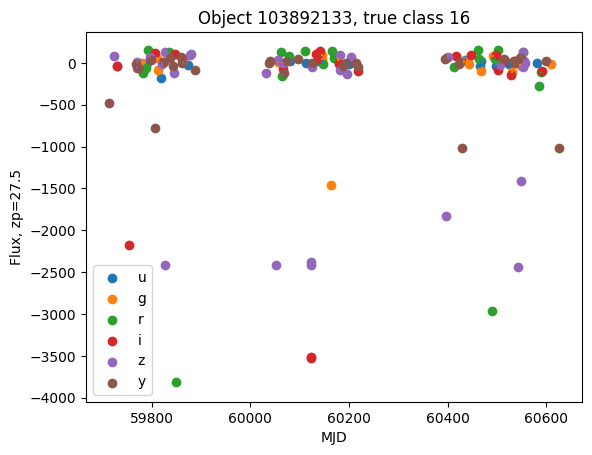

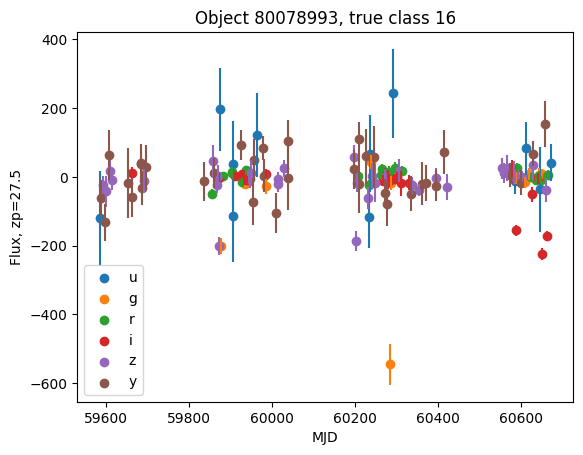

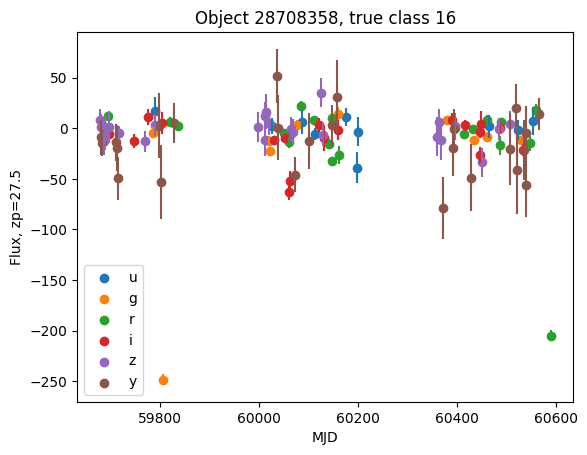

In [7]:
import matplotlib.pyplot as plt

LSST_BANDS = 'ugrizy'

def plot(row):
    plt.figure()
    plt.title(f"Object {row.Index}, true class {row.true_target}")
    plt.xlabel('MJD')
    plt.ylabel('Flux, zp=27.5')
    for band_idx, band_name in enumerate(LSST_BANDS):
        mjd, flux, flux_err = extract_band(
            row.mjd,
            row.flux,
            row.flux_err,
            bands=row.passband,
            band_to_calc=band_idx,
        )
        color = f'C{band_idx}'
        plt.scatter(mjd, flux, c=color, label=band_name)
        plt.errorbar(mjd, flux, yerr=flux_err, ls='none', c=color)
        plt.legend()

# Random objects from the selected sample
for row in object_table[object_table['true_target'] == 16].sample(5, random_state=0).itertuples():
    plot(row)
    
# Random objects from the selected sample
for row in df.sample(5, random_state=0).itertuples():
    plot(row)

In [23]:
object_table['mjd'].apply(lambda t: t.ctypes.data)

13           20468334592
14           20468337232
17           20468339872
23           20468342688
34           20468345328
                ...     
130787966    24097554064
130787971    24097555224
130787974    24097556344
130788053    24097557480
130788054    24097558304
Name: mjd, Length: 3492890, dtype: int64

In [21]:
object_table.apply(lambda row: row['mjd'].ctypes.data, axis=1)

13           20468334592
14           20468337232
17           20468339872
23           20468342688
34           20468345328
                ...     
130787966    24097554064
130787971    24097555224
130787974    24097556344
130788053    24097557480
130788054    24097558304
Length: 3492890, dtype: int64

In [34]:
print(np.diff(pa.array(object_table['mjd']).chunks[0].offsets))
object_table['mjd'].apply(lambda t: t.ctypes.data).diff() / 8

[330 330 352 ... 350 255 255]


13             NaN
14           330.0
17           330.0
23           352.0
34           330.0
             ...  
130787966    139.0
130787971    145.0
130787974    140.0
130788053    142.0
130788054    103.0
Name: mjd, Length: 3492890, dtype: float64